# Notebook 1, Image Generation
### Marsha Genevieve Nandana - 2702217522

In [16]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
import time

import glob
from PIL import Image


# 2a. Construct and train a deep learning model as an image generator by using the images in your training dataset to train the model.

In [17]:
#gen dcgan

LATENT_DIM = 100
IMG_SIZE = 64 #ukuran gambar yang bakal dihasilin
def build_generator():
    model = keras.Sequential(name="Generator")

    #1. vecotr noise 1D jadi fondasi 3D (4x4)
    model.add(layers.Dense(4 * 4 * 1024, input_shape=(LATENT_DIM,)))
    model.add(layers.Reshape((4, 4, 1024)))
    
    #Conv2DTranspose utk memperbesar gambar
    #2. upsampling 4x4 -> 8x8
    model.add(layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU()) # Aktivasi ReLU di generator

    #3. upsampling 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    #4. upsampling 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    #5. output 32x32 -> 64x64
    #filterny 3 (RGB)
    model.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same'))
    
   
    #'tanh' -> output pixel antara -1 dan 1.
    model.add(layers.Activation('tanh'))

    return model


generator = build_generator()
generator.summary()

/opt/homebrew/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 16384)          │     1,654,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 8, 8, 512)      │     8,389,120 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 64, 64, 3)      │         6,147 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,675,459 (48.35 MB)

 Trainable params: 12,673,667 (48.35 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [18]:
#size image yg bakal ditertima, hrs sama sama generator
IMG_SIZE = 64

def build_discriminator():
    model = keras.Sequential(name="Discriminator")
    
    #input nya gambar 64x64x3
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    
    #1. downsampling 1 (64x64 -> 32x32)
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same'))
    # LeakyReLU sangat direkomendasikan untuk Discriminator
    model.add(layers.LeakyReLU(alpha=0.2))

    #2. downsampling 2 (32x32 -> 16x16)
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    #3. downsampling 3 (16x16 -> 8x8)
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    #4. downsampling 4 (8x8 -> 4x4)
    model.add(layers.Conv2D(512, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    #5. output layer (klasifikasi)
    #Ubah dari 3D (4x4x512) menjadi 1D
    model.add(layers.Flatten())
    
    #Dropout untuk mencegah overfitting
    model.add(layers.Dropout(0.4)) 
    model.add(layers.Dense(1)) 
    
    #activation pake sigmoid untuk probability (0 =fake, 1 =real)

    ####JGNNN pakai sigmoid di sini kalau pakai loss 'from_logits=True' nnti cb
    #skrg gapake aktivasi dlu (ini logits)

    return model

discriminator = build_discriminator()
discriminator.summary()


/opt/homebrew/anaconda3/envs/myenv/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [19]:
IMAGE_SIZE = 64
BATCH_SIZE = 64 
DATA_DIR = "./train/whale" 

#bikin dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels=None, # none krn gabutuh
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    interpolation='nearest' #nearest sering dipakai di GAN
)

#normalisasi (0-255 -> -1 sampai 1)
def normalize(image):
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    return image
train_dataset = train_dataset.map(normalize)

#pecah batch nya jadi gambar individual
train_dataset = train_dataset.unbatch()

train_dataset = train_dataset.cache().shuffle(1000).batch(
    BATCH_SIZE, 
    drop_remainder=True  # BUANG BATCH TERAKHIR KLO UKURANNYA < 64 gpp hasilnya ga 500 bgt
).prefetch(buffer_size=tf.data.AUTOTUNE)

print("tes")
print(next(iter(train_dataset)).shape)

Found 500 files.
tes
(64, 64, 64, 3)


In [ ]:
#tambahkan @tf.function agar tf ngomcompile
#fungsi inj jadi graph yang cepet
@tf.function
def train_step(real_images):
    #bikin noise acak untuk Generator
    #(BATCH_SIZE, LATENT_DIM)
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    #train discriminator
    with tf.GradientTape() as disc_tape:
        #bikin gambar fake
        generated_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #loss discriminator
        #loss untuk gambar asli: bandingkan tebakan (real_output) dengan label 1
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        #loss untuk gambar palsu: bandingkan tebakan (fake_output) dengan label 0
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        #loss total Discriminator
        disc_loss = real_loss + fake_loss

    #gradien & update weights Discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


    #train generatro
    with tf.GradientTape() as gen_tape:
        #gambar fake lagi
        generated_images = generator(noise, training=True)
        #tebakan discriminator (ini bagian 'menipu'-nya)
        fake_output = discriminator(generated_images, training=True)

        #biar disc nebak gambar palsu ebagai asli (label 1)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return disc_loss, gen_loss

In [21]:
EPOCHS = 500 #kyknya kl mau bagus hrs >2000
SAVE_EVERY_N_EPOCHS = 10 #save tiap 10 epoch

seed = tf.random.normal([16, LATENT_DIM])

cross_entropy = losses.BinaryCrossentropy(from_logits=True)

g_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

#buat 2b
generator_losses = []
discriminator_losses = []



def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2.0) 
        plt.axis('off')


    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.close(fig) 

#trainig loop
for epoch in range(EPOCHS):
    start_time = time.time()
    
    

    total_gen_loss = 0
    total_disc_loss = 0
    num_batches = 0


    for image_batch in train_dataset:
        disc_loss, gen_loss = train_step(image_batch)
      
        total_gen_loss += gen_loss
        total_disc_loss += disc_loss
        num_batches += 1

    avg_gen_loss = total_gen_loss / num_batches
    avg_disc_loss = total_disc_loss / num_batches
    
    generator_losses.append(avg_gen_loss)
    discriminator_losses.append(avg_disc_loss)

    print(f'Epoch {epoch + 1}/{EPOCHS} - time: {time.time() - start_time:.2f} sec')
    print(f'  Avg Generator Loss: {avg_gen_loss:.4f} | Avg Discriminator Loss: {avg_disc_loss:.4f}')

    if (epoch + 1) % SAVE_EVERY_N_EPOCHS == 0:
        generate_and_save_images(generator, epoch + 1, seed)
        print(f'  >>> image_at_epoch_{epoch + 1:04d}.png')

print("done")

#2c
generator.save('whale_generator_model_500epochs.h5')

2025-11-16 15:17:47.174802: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/500 - time: 22.00 sec
  Avg Generator Loss: 5.0017 | Avg Discriminator Loss: 1.2992


2025-11-16 15:18:05.175781: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/500 - time: 18.00 sec
  Avg Generator Loss: 8.3885 | Avg Discriminator Loss: 0.8191
Epoch 3/500 - time: 17.99 sec
  Avg Generator Loss: 12.2306 | Avg Discriminator Loss: 1.4575


2025-11-16 15:18:41.288406: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/500 - time: 18.13 sec
  Avg Generator Loss: 11.6292 | Avg Discriminator Loss: 0.8212
Epoch 5/500 - time: 18.17 sec
  Avg Generator Loss: 7.9320 | Avg Discriminator Loss: 0.2999
Epoch 6/500 - time: 18.12 sec
  Avg Generator Loss: 8.0319 | Avg Discriminator Loss: 0.2131
Epoch 7/500 - time: 17.98 sec
  Avg Generator Loss: 7.5372 | Avg Discriminator Loss: 0.1417


2025-11-16 15:19:53.717449: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/500 - time: 18.15 sec
  Avg Generator Loss: 7.9592 | Avg Discriminator Loss: 0.2215
Epoch 9/500 - time: 18.09 sec
  Avg Generator Loss: 6.4565 | Avg Discriminator Loss: 0.3437
Epoch 10/500 - time: 18.77 sec
  Avg Generator Loss: 6.1498 | Avg Discriminator Loss: 0.4128
  >>> image_at_epoch_0010.png
Epoch 11/500 - time: 18.13 sec
  Avg Generator Loss: 5.2658 | Avg Discriminator Loss: 0.4629
Epoch 12/500 - time: 18.11 sec
  Avg Generator Loss: 5.3474 | Avg Discriminator Loss: 0.5308
Epoch 13/500 - time: 18.19 sec
  Avg Generator Loss: 4.6313 | Avg Discriminator Loss: 0.9201
Epoch 14/500 - time: 19.73 sec
  Avg Generator Loss: 4.0024 | Avg Discriminator Loss: 0.9073
Epoch 15/500 - time: 20.21 sec
  Avg Generator Loss: 3.8335 | Avg Discriminator Loss: 0.8559


2025-11-16 15:22:29.194261: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/500 - time: 23.95 sec
  Avg Generator Loss: 3.5230 | Avg Discriminator Loss: 0.7924
Epoch 17/500 - time: 21.12 sec
  Avg Generator Loss: 3.9164 | Avg Discriminator Loss: 0.9669
Epoch 18/500 - time: 18.26 sec
  Avg Generator Loss: 3.6932 | Avg Discriminator Loss: 0.8925
Epoch 19/500 - time: 19.73 sec
  Avg Generator Loss: 3.4031 | Avg Discriminator Loss: 1.0278
Epoch 20/500 - time: 20.00 sec
  Avg Generator Loss: 3.5962 | Avg Discriminator Loss: 0.8692
  >>> image_at_epoch_0020.png
Epoch 21/500 - time: 17.94 sec
  Avg Generator Loss: 3.7626 | Avg Discriminator Loss: 1.0655
Epoch 22/500 - time: 19.90 sec
  Avg Generator Loss: 3.9753 | Avg Discriminator Loss: 0.9104
Epoch 23/500 - time: 17.83 sec
  Avg Generator Loss: 3.7303 | Avg Discriminator Loss: 1.1007
Epoch 24/500 - time: 17.75 sec
  Avg Generator Loss: 3.3435 | Avg Discriminator Loss: 0.8693
Epoch 25/500 - time: 17.51 sec
  Avg Generator Loss: 4.0862 | Avg Discriminator Loss: 0.9472
Epoch 26/500 - time: 17.49 sec
  Avg Gen

2025-11-16 15:27:26.030890: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32/500 - time: 18.39 sec
  Avg Generator Loss: 3.1361 | Avg Discriminator Loss: 0.8112
Epoch 33/500 - time: 18.37 sec
  Avg Generator Loss: 4.0750 | Avg Discriminator Loss: 1.0866
Epoch 34/500 - time: 18.27 sec
  Avg Generator Loss: 3.7585 | Avg Discriminator Loss: 1.0898
Epoch 35/500 - time: 18.36 sec
  Avg Generator Loss: 3.0912 | Avg Discriminator Loss: 0.6395
Epoch 36/500 - time: 18.38 sec
  Avg Generator Loss: 2.9492 | Avg Discriminator Loss: 0.7036
Epoch 37/500 - time: 18.33 sec
  Avg Generator Loss: 3.4094 | Avg Discriminator Loss: 0.6759
Epoch 38/500 - time: 18.34 sec
  Avg Generator Loss: 3.4127 | Avg Discriminator Loss: 0.9829
Epoch 39/500 - time: 18.64 sec
  Avg Generator Loss: 3.3181 | Avg Discriminator Loss: 0.5936
Epoch 40/500 - time: 18.16 sec
  Avg Generator Loss: 3.5728 | Avg Discriminator Loss: 0.6872
  >>> image_at_epoch_0040.png
Epoch 41/500 - time: 18.25 sec
  Avg Generator Loss: 3.1053 | Avg Discriminator Loss: 0.8698
Epoch 42/500 - time: 18.23 sec
  Avg Gen

2025-11-16 15:36:41.211488: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64/500 - time: 7.80 sec
  Avg Generator Loss: 2.8466 | Avg Discriminator Loss: 0.8495
Epoch 65/500 - time: 8.22 sec
  Avg Generator Loss: 2.5230 | Avg Discriminator Loss: 0.5951
Epoch 66/500 - time: 8.29 sec
  Avg Generator Loss: 2.6994 | Avg Discriminator Loss: 0.5632
Epoch 67/500 - time: 8.35 sec
  Avg Generator Loss: 2.7578 | Avg Discriminator Loss: 0.6941
Epoch 68/500 - time: 8.30 sec
  Avg Generator Loss: 2.7189 | Avg Discriminator Loss: 0.6177
Epoch 69/500 - time: 8.36 sec
  Avg Generator Loss: 2.5963 | Avg Discriminator Loss: 0.6515
Epoch 70/500 - time: 8.42 sec
  Avg Generator Loss: 2.7137 | Avg Discriminator Loss: 0.7427
  >>> image_at_epoch_0070.png
Epoch 71/500 - time: 8.63 sec
  Avg Generator Loss: 3.6042 | Avg Discriminator Loss: 1.0110
Epoch 72/500 - time: 8.84 sec
  Avg Generator Loss: 2.9111 | Avg Discriminator Loss: 0.6850
Epoch 73/500 - time: 8.84 sec
  Avg Generator Loss: 2.9047 | Avg Discriminator Loss: 0.5648
Epoch 74/500 - time: 9.27 sec
  Avg Generator Loss

2025-11-16 15:48:28.708704: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 128/500 - time: 11.27 sec
  Avg Generator Loss: 3.1280 | Avg Discriminator Loss: 0.2819
Epoch 129/500 - time: 11.30 sec
  Avg Generator Loss: 3.5581 | Avg Discriminator Loss: 0.3536
Epoch 130/500 - time: 11.17 sec
  Avg Generator Loss: 3.1460 | Avg Discriminator Loss: 0.2883
  >>> image_at_epoch_0130.png
Epoch 131/500 - time: 11.21 sec
  Avg Generator Loss: 3.2685 | Avg Discriminator Loss: 0.2588
Epoch 132/500 - time: 11.30 sec
  Avg Generator Loss: 3.3570 | Avg Discriminator Loss: 0.2586
Epoch 133/500 - time: 11.30 sec
  Avg Generator Loss: 3.3851 | Avg Discriminator Loss: 0.2801
Epoch 134/500 - time: 11.34 sec
  Avg Generator Loss: 3.4189 | Avg Discriminator Loss: 0.2740
Epoch 135/500 - time: 11.30 sec
  Avg Generator Loss: 3.9058 | Avg Discriminator Loss: 0.7098
Epoch 136/500 - time: 11.31 sec
  Avg Generator Loss: 4.4681 | Avg Discriminator Loss: 1.1554
Epoch 137/500 - time: 11.29 sec
  Avg Generator Loss: 3.7260 | Avg Discriminator Loss: 0.5298
Epoch 138/500 - time: 11.33 se

2025-11-16 16:13:12.744509: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 256/500 - time: 11.69 sec
  Avg Generator Loss: 4.1805 | Avg Discriminator Loss: 0.0850
Epoch 257/500 - time: 11.71 sec
  Avg Generator Loss: 4.4334 | Avg Discriminator Loss: 0.1018
Epoch 258/500 - time: 11.67 sec
  Avg Generator Loss: 4.2820 | Avg Discriminator Loss: 0.0820
Epoch 259/500 - time: 11.73 sec
  Avg Generator Loss: 4.3801 | Avg Discriminator Loss: 0.0808
Epoch 260/500 - time: 11.74 sec
  Avg Generator Loss: 4.3397 | Avg Discriminator Loss: 0.0802
  >>> image_at_epoch_0260.png
Epoch 261/500 - time: 11.77 sec
  Avg Generator Loss: 4.4156 | Avg Discriminator Loss: 0.0856
Epoch 262/500 - time: 11.80 sec
  Avg Generator Loss: 4.5878 | Avg Discriminator Loss: 0.0794
Epoch 263/500 - time: 11.93 sec
  Avg Generator Loss: 4.5090 | Avg Discriminator Loss: 0.0894
Epoch 264/500 - time: 11.86 sec
  Avg Generator Loss: 4.5267 | Avg Discriminator Loss: 0.0758
Epoch 265/500 - time: 12.09 sec
  Avg Generator Loss: 4.4643 | Avg Discriminator Loss: 0.0766
Epoch 266/500 - time: 12.58 se

Epoch 500/500 - time: 12.36 sec
  Avg Generator Loss: 6.4944 | Avg Discriminator Loss: 0.0154
  >>> image_at_epoch_0500.png
done


# 2b. Plot the training and validation losses over epochs, analyze, and explain what happened in the generative training based on the plot

### look at "outputVisuals500epochs.gif"

Visualization dari model GAN ini (seperti yang terlihat pada gif) menunjukkan karakteristik lumayan adversarial.

- Awal (Epoch 1-50): Terjadi mode collapse awal, di mana Generator hanya menghasilkan pola noise biru yang blur.
- Tengah (Epoch 50-200): Kualitas image mulai membaik, menunjukkan bentuk-bentuk yang lebih menyerupai whale (walaupun masih blur). Ini terjadi karena Generator menemukan cara menipu Discriminator.
- Lanjut (Epoch 300+): Kualitas gambar terlihat naik-turun. Ini normal dalam training GAN, di mana Discriminator mulai men-push Generator, memaksa Generator mencari strategi baru (yang kadang hasilnya lebih jelek sementara).

In [ ]:
#bikin gifnya

FILE_PATTERN = "image_at_epoch_*.png"
OUTPUT_GIF = "gan_training_500epochs.gif"
FRAME_DURATION = 200 


image_files = sorted(glob.glob(FILE_PATTERN))

if not image_files:
    print(f"cek dir'{FILE_PATTERN}'")

else:
    print(f"{len(image_files)} images")


    frames = []
    for filename in image_files:
        try:
            frames.append(Image.open(filename))
        except Exception as e:
            print(f"failed openign membuka {filename}: {e}")


    if frames:
        frames[0].save(
            OUTPUT_GIF,
            save_all=True,
            append_images=frames[1:],  
            duration=FRAME_DURATION, #duration per frame
            loop=0                     
        )
        print(f"tes {os.path.abspath(OUTPUT_GIF)}")
    else:
        print("fail")

50 images
tes /Users/genevieve/College/Semester 5/Deep Learning/MidTerm/CIFAR-100-dataset-main/gan_training_500epochs.gif


# 2d. Compare 10 generated images and 10 original images, analyze and explain the comparison.

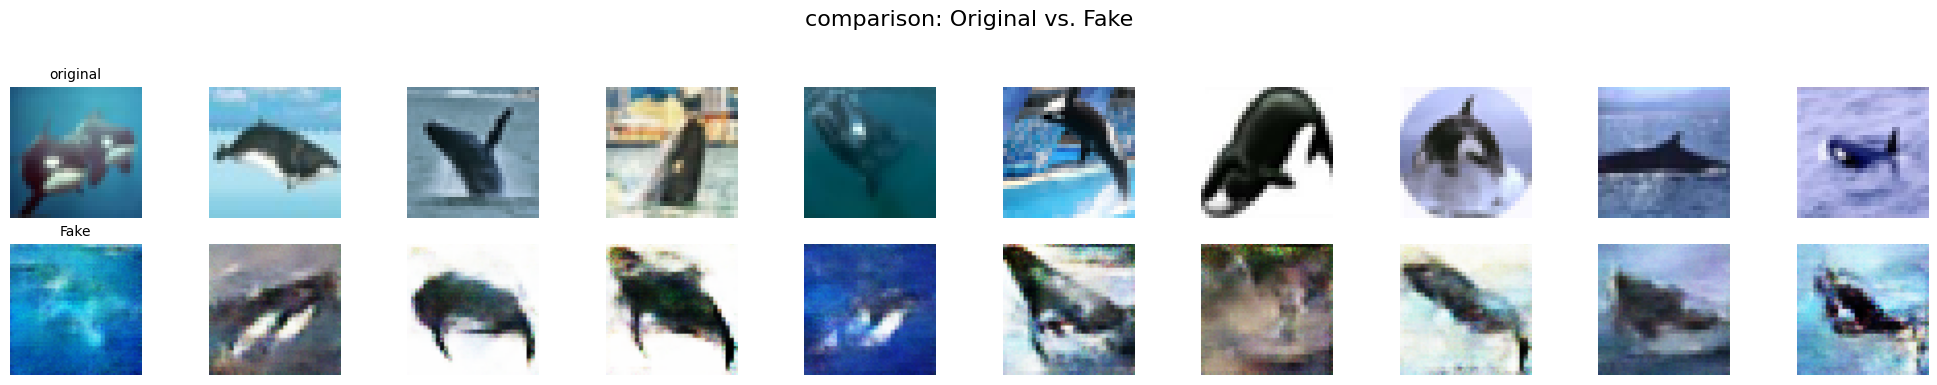

In [23]:

ORIGINAL_DATA_DIR = "./train/whale"
GENERATED_FOLDER = "generated_fake_images"
NUM_TO_COMPARE = 10

try:
    original_files = os.listdir(ORIGINAL_DATA_DIR)[:NUM_TO_COMPARE]
    fake_files = os.listdir(GENERATED_FOLDER)[:NUM_TO_COMPARE]
except FileNotFoundError:
    print(f"cek dirnya")
    original_files = []
    fake_files = []


if original_files and fake_files:
    plt.figure(figsize=(20, 4))
    plt.suptitle('comparison: Original vs. Fake', fontsize=16)

    for i in range(NUM_TO_COMPARE):
        #ori
        ax = plt.subplot(2, NUM_TO_COMPARE, i + 1) 
        img_path = os.path.join(ORIGINAL_DATA_DIR, original_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title("original", fontsize=10)

        #fake
        ax = plt.subplot(2, NUM_TO_COMPARE, i + 1 + NUM_TO_COMPARE) 
        img_path = os.path.join(GENERATED_FOLDER, fake_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title("Fake", fontsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()
else:
    print("salah dir")

Gambar Asli: Lebih clear(jelas), memiliki detail dan variasi bentuk/pose yang natural.

Gambar Palsu (generated): Cenderung lebih blur, memiliki artifact (keanehan visual/bercak), dan kurang detail. Pola yang dihasilkan cenderung mirip satu sama lain (kurang variatif), yang menunjukkan sisa-sisa mode collapse dari training GAN.

Dengan dataset yang ada, mungkin bisa dibilang bahwa model belum menguasai keseluruhan anatomi dari whale ini, maka ada beberapa gambar yang hasilnya benar-benar asal/abstract